# Energy Function


Energy function to solve the optimization problem of finding the **shortest path** between two nodes in a graph. This function combines multiple terms that impose constraints and objectives on the solution. Here is a general energy function for finding shortest paths without particularizing to a specific (orgin,destination) pair:

$$
F = \frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij} + 
    \frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij}) 
$$

## Components of the Energy Function

### 1. **Path Cost**
$$
\frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij}
$$
- **Description**: Minimizes the total cost of the path.
- **Variables**:
  - $C_{ij} $: Cost (or distance) between nodes $i$ and $j$.
  - $x_{ij} $: Binary variable indicating if the path between $i $ and $j$ is part of the solution $( x_{ij} = 1 $) or not $( x_{ij} = 0 $).
- **Purpose**: Encourges the selection of paths with lower cost.

---

### 2. **Row constraints**
$
\frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2
$
- **Description**: This term ensures that each node has exactly **one outgoing edge**.
- **Variables**:
  - $\sum_{j=1}^n x_{ij} $: Represents number of outgoing edges from node $i$
- **Purpose**: Penalize solutions in which a node has more than one outgoing edge or none.

---

### 3. **Column constraints**
$
\frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2
$
- **Description**: This term ensures that each node has exactly **one incoming edge**.
- **Variables**:
  - $\sum_{i=1}^n x_{ij} $: Represents number of incoming edges to node $j$.
- **Purpose**: Penalize solutions in which a node has more than one incoming edge or none. 

---

### 4. **Binariness constraint**
$
\frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij})
$
- **Description**: This term forces the variables $( x_{ij} $) to be binary (0 or 1).
- **Variables**:
  - $x_{ij} (1 - x_{ij}) $: This product is zero if $( x_{ij} $) is 0 or 1, but is positive if $( x_{ij} $) takes intermediate values.
- **Purpose**: Penalize solutions in which $x_{ij} $ takes values other than 0 or 1.

---

## Parameters
- $\mu_1, \mu_2, \mu_3 $: Weights that balance the importance of each term in the energy function. 
  - $ \mu_1 $: Prioritizes the minimization of the total cost of the path. 
  - $ \mu_2 $: Emphasis on path validity. 
  - $ \mu_3 $: Controls the binariness of the variables. 

---

## Summary
Energy Function combines **strong** (like path validity) and **weak** (like cost minimization and binariness) constraints to: 
1. **Find a valid path**.
2. **Minimize the total cost of the path**.



---

## DATA PREPARATION
Transform the adjacency matrix into a cost matrix.

In [1]:
import pandas as pd
import numpy as np

# Load data from CSV file
try:
    df = pd.read_csv('../data/synthetic/synthetic_network.csv')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except pd.errors.EmptyDataError:
    print("Error: The file is empty or invalid.")
    exit()

# Identify unique nodes and create a mapping for indices
nodos = sorted(set(df['origin']).union(set(df['destination'])))
node_to_index = {node: idx for idx, node in enumerate(nodos)}
n = len(nodos)

# Initialize the cost matrix with infinity
cost_matrix = np.full((n, n), np.inf)


# Set diagonal to 0 (self-costs)
np.fill_diagonal(cost_matrix, 0)

# Fill the cost matrix with the values from the CSV
for _, row in df.iterrows():
    try:
        origen = row['origin']
        destino = row['destination']
        costo = float(row['weight'])
        cost_matrix[node_to_index[origen], node_to_index[destino]] = costo
    except KeyError:
        print("Error: Missing columns 'origen', 'destino', or 'costo'.")
        exit()
    except ValueError:
        print(f"Error: Invalid cost value on row {_}.")
        exit()

# Display the cost matrix
print("Cost Matrix:")
print(cost_matrix)




Cost Matrix:
[[  0.  inf 762. ... 571. 825.  inf]
 [ inf   0. 370. ...  inf  inf  inf]
 [911. 601.   0. ...  inf  inf 684.]
 ...
 [ inf  inf 690. ...   0.  inf  inf]
 [418.  83.  inf ... 259.   0.  inf]
 [ inf 325.  inf ...  inf 700.   0.]]


---

## NEURAL MODEL

In [2]:

from math import sqrt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import register_keras_serializable

# Check GPU availability 
if tf.config.list_physical_devices('XPU'):  # 'XPU' Intel GPU devices
    device = '/XPU:0'
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'
print("Device:", device)

# Load, normalize and flatten the distance matrix, assigning a large value to infinity values
cost_matrix = np.array(df.pivot(index='origin', columns='destination', values='weight').fillna(1e6))
cost_matrix[cost_matrix == np.inf] = 1e12
cost_matrix_normalized = (cost_matrix - np.min(cost_matrix)) / (np.max(cost_matrix) - np.min(cost_matrix) + 1e-6)
cost_matrix_flat = cost_matrix_normalized.flatten()
distance_matrix = cost_matrix_flat


# Number of nodes
n = distance_matrix.shape[0]
print("Number of nodes:", n)


# Hyperparameters (weights for energy terms)
mu1 = 1.0
mu2 = 10.0
mu3 = 10.0

# Define the Hopfield Neural Network layer
@register_keras_serializable()
class HopfieldLayer(Layer):
    def __init__(self, n, distance_matrix, **kwargs):
        super(HopfieldLayer, self).__init__(**kwargs)
        self.n = n
        self.distance_matrix = tf.constant(distance_matrix, dtype=tf.float32)
        self.x = self.add_weight(
            name="x", 
            shape=(n, n), 
            initializer="random_uniform", 
            trainable=True
        )
        self.optimizer = tf.optimizers.Adam(learning_rate=0.01)
        # Valid arcs
        self.valid_arcs = tf.constant((self.distance_matrix.numpy() != 0).astype(np.float32), dtype=tf.float32)
                                         
    def energy(self):
        path_cost = tf.reduce_sum(self.distance_matrix * self.x)
        row_constraint = tf.reduce_sum(tf.square(tf.reduce_sum(self.x, axis=1) - 1))
        col_constraint = tf.reduce_sum(tf.square(tf.reduce_sum(self.x, axis=0) - 1))
        binary_constraint = tf.reduce_sum(tf.square(self.x * (1 - self.x)))
        invalid_arcs_penalty = tf.reduce_sum(tf.square(self.x * (1 - self.valid_arcs)))
        return (mu1/2)*path_cost + (mu2/2)*row_constraint + (mu2/2)*col_constraint + (mu3/2)*binary_constraint + 1000*invalid_arcs_penalty	
        
    
    def fine_tune_with_constraints(self, source, destination, iterations=500):
        print("Initial Energy:", self.energy().numpy())
        for i in range(iterations):
            with tf.GradientTape() as tape:
                # Fine-tune with source and destination constraints
                source_out = tf.reduce_sum(self.x[source, :]) - 1
                term5 = (10.0 / 2) * tf.square(source_out)

                dest_in = tf.reduce_sum(self.x[:, destination]) - 1
                term6 = (10.0 / 2) * tf.square(dest_in)

                energy = self.energy() + term5 + term6

            gradients = tape.gradient(energy, [self.x])
            self.optimizer.apply_gradients(zip(gradients, [self.x]))
            # Clip the variables to [0, 1] to enforce valid range
            self.x.assign(tf.clip_by_value(self.x, 0.0, 1.0))
            if i % 100 == 0:
                print(f"Fine-Tuning Iteration {i}, Energy: {energy.numpy()}")
        print("Final Energy:", self.energy().numpy())
        return self.x
    
    def call(self, inputs, training=False):
        return self.x
    
    def compile(self, optimizer):
        super(HopfieldLayer, self).compile()
        
    def get_config(self):
        config = super(HopfieldLayer, self).get_config()
        config.update({
            'n': self.n,
            'distance_matrix': self.distance_matrix.numpy().tolist(),
            'x': self.x.numpy().tolist(),
            'valid_arcs': self.valid_arcs.numpy().tolist() 
        })
        return config

    @classmethod
    def from_config(cls, config):
        x = config.pop('x')
        distance_matrix = config.pop('distance_matrix')
        instance = cls(distance_matrix=distance_matrix, **config)
        instance.x.assign(tf.constant(x, dtype=tf.float32))  # Restore self.x from the configuration
        valid_arcs = config.pop('valid_arcs')
        instance.valid_arcs.assign(tf.constant(valid_arcs, dtype=tf.float32))  # Restore self.valid_arcs from the configuration
        return instance

#Integrate custom HopfieldLayer with Keras model
@register_keras_serializable()
class HopfieldModel(Model):
    def __init__(self, n, distance_matrix, **kwargs):
        super(HopfieldModel, self).__init__(**kwargs)
        self.hopfield_layer = HopfieldLayer(n, distance_matrix)
        self.optimizer = tf.optimizers.Adam(learning_rate=0.01)

    def train_step(self, data):
        # Custom training logic
        with tf.GradientTape() as tape:
            # Compute the energy as the loss
            loss = self.hopfield_layer.energy()
        # Compute gradients and apply updates
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Return the loss
        return {"loss": loss}
    
    def call(self, inputs, training=False):
        # Forward pass
        return self.hopfield_layer(inputs, training=training)
    
    def predict(self,source,destination):
        self.hopfield_layer.fine_tune_with_constraints(source, destination)
        # Retrieve the optimized state matrix
        state_matrix = tf.round(self.hopfield_layer.x).numpy()

        # Extract the shortest path based on the state matrix
        def extract_path(state_matrix):
            path = []
            current_node = source
            visited = set()

            while current_node != destination:
                path.append(current_node)
                visited.add(current_node)
                # Find the next node
                next_node = np.argmax(state_matrix[current_node])
                if next_node in visited or next_node == destination:
                    break
                current_node = next_node

            path.append(destination)
            return path

        # Extract and return the predicted path
        return extract_path(state_matrix)
       
    def get_config(self):
        config = super(HopfieldModel, self).get_config()
        config.update({
            'n': self.hopfield_layer.n,
            'distance_matrix': self.hopfield_layer.distance_matrix.numpy().tolist()
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
  
             
# Create the model
model = HopfieldModel(n, distance_matrix)
# Compile the model with a custom optimizer
with tf.device(device):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
    # Ensure distance_matrix is a valid tensor and reshape it to match the expected input shape
    m = int(sqrt(n))
    distance_matrix_tensor = tf.constant(distance_matrix, dtype=tf.float32)
    distance_matrix_tensor = tf.reshape(distance_matrix_tensor, (m, m))  
    distance_matrix_tensor = tf.reshape(distance_matrix_tensor, (1, m, m))  
    # Create dummy target data as it is required by the fit method
    dummy_target = tf.zeros((1, n, n), dtype=tf.float32)
    # Train the model to minimize the energy function
    model(dummy_target)
    model.fit(dummy_target, epochs=1000)
    model.summary()

# Save the trained model
model.save("../models/trained_model_without_source_dest.keras")
    


2025-01-06 09:53:27.567428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 09:53:27.575844: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 09:53:27.649977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 09:53:27.724499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736153607.798290   11482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736153607.82

Device: /CPU:0
Number of nodes: 2500
Epoch 1/1000


2025-01-06 09:53:30.158408: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 53453.0156 
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4016990.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 876356.7500 
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1616161.1250
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1428521.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 771097.1875 
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1036877.0000
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1363029.8750
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 962149.6875 
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 259813.3438
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 44132.3828
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 431248.2188
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 782049.4375 
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 683176.0000 
Epoc

Model: "hopfield_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hopfield_layer (HopfieldLayer)  │ ?                      │     6,250,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,750,002 (71.53 MB)

 Trainable params: 6,250,000 (23.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,500,002 (47.68 MB)

## Source and destination node restrictions

**Term 5: Source Node Constraint**

$
\left( \sum_{j=1}^n x_{s,j} - 1 \right)^2
$

- $x_{s,j}$: Binary decision variable for the edge from source node $s$ to node $j$.
- Ensures that the source node $s$ has exactly one outgoing edge.

**Term 6: Destination Node Constraint**

$
\left( \sum_{i=1}^n x_{i,d} - 1 \right)^2
$

- $ x_{i,d} $: Binary decision variable for the edge from node $ i $ to the destination node $ d $.
- Ensures that the destination node $ d $ has exactly one incoming edge.


### Fine tuning with source and destination constraints

In [3]:
import numpy as np
import tensorflow as tf

source_node = 27
destination_node = 5

# Register the custom layer when loading the model
with tf.keras.utils.custom_object_scope({'HopfieldModel': HopfieldModel, 'HopfieldLayer': HopfieldLayer}):
    # Load the model with custom objects
    loaded_model = tf.keras.models.load_model('../models/trained_model_without_source_dest.keras', custom_objects={'HopfieldModel': HopfieldModel, 'HopfieldLayer': HopfieldLayer})
# Recompile the model with a new optimizer
loaded_model.compile(optimizer=Adam(learning_rate=0.1))

# Predict the shortest path from the source to the destination node
path = loaded_model.predict(source_node, destination_node)
print("Predicted Path:", path)

Initial Energy: 764.8249
Fine-Tuning Iteration 0, Energy: 764.8271484375
Fine-Tuning Iteration 100, Energy: 746.8818359375
Fine-Tuning Iteration 200, Energy: 742.4540405273438
Fine-Tuning Iteration 300, Energy: 742.5899047851562
Fine-Tuning Iteration 400, Energy: 3459.55517578125
Final Energy: 18947.309
Predicted Path: [27, np.int64(0), 5]


### Cost of the shortest path

In [4]:
# Calculate the cost of the shortest path
# Adjusted to account for the real cost matrix (not normalized)
def calculate_real_path_cost(real_cost_matrix, path):
    cost = 0
    for i in range(len(path) - 1):
        cost += real_cost_matrix[path[i], path[i + 1]]
    return cost

path_cost = calculate_real_path_cost(cost_matrix, path)
print("Cost of the Shortest Path (Real Costs):", path_cost)

Cost of the Shortest Path (Real Costs): 992.0


### Visualization of the shortest path

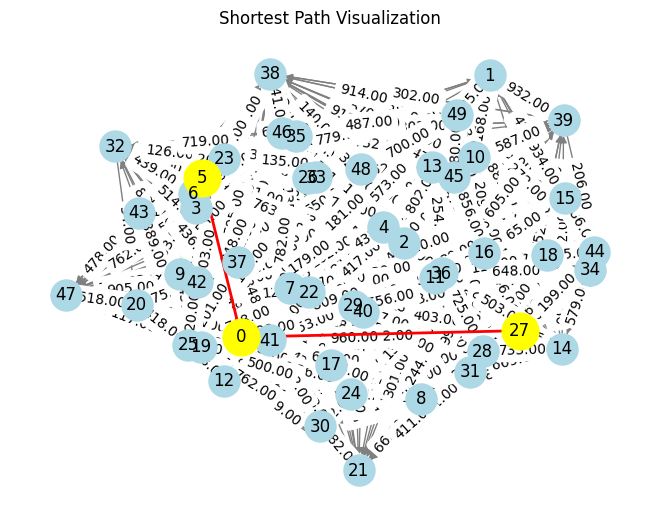

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualization of the shortest path using NetworkX
def visualize_shortest_path(real_cost_matrix, shortest_path):
    G = nx.DiGraph()
    n = real_cost_matrix.shape[0]

    # Add edges with weights
    for i in range(n):
        for j in range(n):
            if real_cost_matrix[i, j] < 1e6:  # Exclude large values (representing infinity)
                G.add_edge(i, j, weight=real_cost_matrix[i, j])

    # Generate positions for nodes
    pos = nx.spring_layout(G)

    # Draw the entire graph
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{d['weight']:.2f}" for i, j, d in G.edges(data=True)})

    # Highlight the shortest path
    path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color="yellow", node_size=700)

    plt.title("Shortest Path Visualization")
    plt.show()

visualize_shortest_path(cost_matrix, path)

